In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from firefly.data_reader.GAIAreader import GaiaReader

palettable colormaps are not installed
don't have phil's colormaps


In [3]:
import os
import numpy as np

In [82]:

gaiadir = os.path.join(os.environ['HOME'],'projects','gaia','GaiaSource')
my_reader = GaiaReader(
    nthreads=52,
    write_startup=True,
    clean_datadir=True,
    use_mps=True,
    min_to_refine=1e5/10,
    nrecurse=10)


2.090136210123698e-06 min elapsed
Make sure each field_array (3) has a field_filter_flag (0), assuming True.
Make sure each field_array (3) has a field_colormap_flag (0), assuming True.

1.2596448262532552e-06 min elapsed
Make sure each field_array (3) has a field_filter_flag (0), assuming True.
Make sure each field_array (3) has a field_colormap_flag (0), assuming True.
datadir: /home/abg6257/projects/gaia -- is not a sub-directory of firefly/static/data. 
This may produce confusing or inoperable results. As such, we will create a symlink for you when you writeToDisk.


In [83]:
data_dicts = my_reader.retrieve_gaia_data(return_arrays=True)

Progress: |--------------------------------------------------| 1.5% complete
173.17736530303955 s elapsed


In [112]:
xs = np.concatenate([data_dict['x'] for data_dict in data_dicts])
ys = np.concatenate([data_dict['y'] for data_dict in data_dicts])
zs = np.concatenate([data_dict['z'] for data_dict in data_dicts])

In [108]:
rs = np.sqrt(xs**2+ys**2+zs**2)

In [113]:
sub_xs = xs[rs < 300]
sub_ys = ys[rs < 300]
sub_zs = zs[rs < 300]

In [105]:
import matplotlib.pyplot as plt
%matplotlib inline

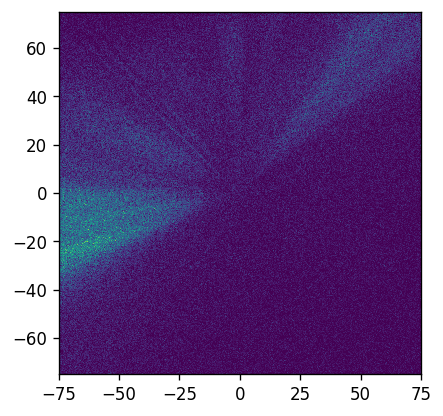

In [128]:
from matplotlib.colors import LogNorm
bins = np.linspace(-75,75,10**3)
plt.hist2d(sub_zs,sub_xs,bins)
plt.gca().set_aspect(1)
plt.gcf().set_dpi(120)
plt.gcf().set_facecolor('white')
print()

In [85]:
data_dicts[0]['x']

array([-3770.70975328,  -552.31160977, -1523.9746656 , ...,
         280.40817132,  2123.44044177,  2031.51468223])

In [61]:
#my_reader.settings['GUIExcludeList'] += ['colorbarcontainer']
my_reader.settings['collapseGUIAtStart'] = False
for pg in my_reader.particleGroups:
    my_reader.settings['sizeMult'][pg.UIname] = 0.1
    my_reader.settings['depthTest'][pg.UIname] = True
    my_reader.settings['blendingMode'][pg.UIname] = 'normal'
    
#my_reader.settings['showParts']['DR3-RV'] = False
my_reader.settings['camera'] = [0,0,0]
my_reader.settings['cameraRotation'] = [-1.5,0,-1.5]
my_reader.settings['startFly'] = True
my_reader.dumpSettingsToJSON()

('/home/abg6257/projects/gaia/GaiaDataSettings.json',
 '/home/abg6257/projects/gaia/GaiaDataSettings.json')

In [62]:
my_reader.writeToDisk(nthreads=52)

DR3-noRV - 966,113,753 parts (31,451 nodes) - 3 fields
DR3-RV - 31,431,382 parts (8,506 nodes) - 3 fields


''

In [23]:
my_reader.copyFireflySourceToTarget('/projects/b1094/ageller/Firefly_ABG/',dump_data=False,overwrite=False,nthreads=52)

['/projects/b1094/ageller/Firefly_ABG/']

In [29]:
%autoreload 0

In [30]:
my_reader.writeToDisk.__code__

<code object writeToDisk at 0x2af7bf0710e0, file "/projects/b1026/agurvich/Firefly/src/firefly/data_reader/reader.py", line 241>

In [38]:
import inspect

In [42]:
import firefly.data_reader.octree as oct

In [43]:
dir(oct)

['BinaryWriter',
 'OctNode',
 'Octree',
 'RawBinaryWriter',
 '__builtins__',
 '__cached__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'convertNodeFFRawFFTree',
 'copy',
 'group_files',
 'init_octree_root_node',
 'itertools',
 'load_from_json',
 'multiprocessing',
 'np',
 'octant_offsets',
 'os',
 'printProgressBar',
 'refineNode',
 'time',
 'validate_files',
 'write_to_json']

In [45]:
print(inspect.getsource(oct.convertNodeFFRawFFTree))

def convertNodeFFRawFFTree(
    node_dict,
    fname,
    field_names):

    if 'files' not in node_dict.keys(): return node_dict

    ## create a new octnode object to translate the data with
    node = OctNode(
        node_dict['center'],
        node_dict['width'],
        field_names,
        node_dict['name'],
        has_velocities=node_dict['com_velocity'] is not None,
        has_colors=node_dict['rgba_color'] is not None) 
    ## load the node's particles from the .ffraw files
    node.set_buffers_from_disk(node_dict['files'],node_dict['buffer_size'])
    return node.write_fftree(fname)



In [37]:
dir(my_reader.writeToDisk)

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__func__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']